## Phase 1A — Project Setup & Data (Kaggle → /content)

In this step, we:
1. Configure the Kaggle API in Google Colab using `kaggle.json`.
2. Download the I-94 traffic dataset **once** using the Kaggle API.
3. Extract the ZIP file into `/content/` (not Google Drive) for faster reads.
4. Load the CSV directly from `/content/...csv` and display basic info.

**Output:** Dataset successfully loaded into a pandas DataFrame (`df`) from `/content/`.


In [23]:
# =========================================
# PHASE 1A: PROJECT SETUP & DATA (KAGGLE)
# =========================================

# 1) Install Kaggle (usually already installed in Colab, but safe)
!pip -q install kaggle

# 2) Upload your kaggle.json when prompted (from Kaggle > Account > Create New API Token)
from google.colab import files
files.upload()  # upload kaggle.json

# 3) Put kaggle.json in the right place + permissions
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# 4) Download the dataset (set to YOUR Kaggle dataset slug)
# Example slug for I-94 dataset is commonly: "fedesoriano/traffic-prediction-dataset"
DATASET_SLUG = "fedesoriano/traffic-prediction-dataset"

!kaggle datasets download -d {DATASET_SLUG} -p /content --force

# 5) Unzip into /content
import zipfile, os, glob

zip_path = glob.glob("/content/*.zip")[0]
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/content")

print("Extracted files:", os.listdir("/content"))

# 6) Locate the CSV and load it from /content (FAST)
import pandas as pd

csv_files = glob.glob("/content/*.csv")
print("CSV files found:", csv_files)

# pick the first CSV (we’ll confirm name once it prints)
csv_path = csv_files[0]

df = pd.read_csv(csv_path)
print("Loaded:", csv_path)
print("Shape:", df.shape)
df.head()


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
License(s): copyright-authors
  0% 0.00/277k [00:00<?, ?B/s]
100% 277k/277k [00:00<00:00, 615MB/s]
Extracted files: ['.config', 'drive', 'lstm_traffic_model.keras', 'traffic.csv', 'app.py', 'traffic-prediction-dataset.zip', 'sample_data']
CSV files found: ['/content/traffic.csv']
Loaded: /content/traffic.csv
Shape: (48120, 4)


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## Phase 1B — Data Cleaning & Baseline Understanding

In this phase, we prepared the I-94 traffic dataset for time-series modeling.

### Key Steps
- Converted `DateTime` into a proper datetime format.
- Sorted data chronologically (mandatory for LSTM models).
- Checked for missing values and duplicates.
- Extracted basic temporal features (hour, day, month, weekday).
- Performed baseline statistical analysis on traffic volume.
- Visualized traffic trends over time and hourly patterns.

### Observations
- Dataset contains **48,120 records** with no missing values.
- Traffic volume shows strong temporal patterns.
- Clear hourly variation confirms suitability for time-series forecasting.
- The `Vehicles` column is selected as the prediction target.

**Output:** Cleaned, time-ordered dataset ready for LSTM sequence generation.


In [24]:
# =========================================
# PHASE 1B: DATA CLEANING & BASELINE EDA
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Re-load dataset explicitly (safe practice)
df = pd.read_csv("/content/traffic.csv")

# 2) Convert DateTime to proper datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# 3) Sort by time (CRITICAL for time-series & LSTM)
df = df.sort_values('DateTime').reset_index(drop=True)

# 4) Basic structure check
print("Dataset Info:")
df.info()

# 5) Missing values check
print("\nMissing values per column:")
print(df.isnull().sum())

# 6) Duplicate check
print("\nDuplicate rows:", df.duplicated().sum())

# 7) Basic statistics for target variable
print("\nVehicles statistics:")
print(df['Vehicles'].describe())

# 8) Time-based feature extraction (for later use)
df['hour'] = df['DateTime'].dt.hour
df['day'] = df['DateTime'].dt.day
df['month'] = df['DateTime'].dt.month
df['dayofweek'] = df['DateTime'].dt.dayofweek

df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB

Missing values per column:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Duplicate rows: 0

Vehicles statistics:
count    48120.000000
mean        22.791334
std         20.750063
min          1.000000
25%          9.000000
50%         15.000000
75%         29.000000
max        180.000000
Name: Vehicles, dtype: float64


,DateTime,Junction,Vehicles,ID,hour,day,month,dayofweek
0,2015-11-01 00:00:00,1,15,20151101001,0,1,11,6
1,2015-11-01 00:00:00,2,6,20151101002,0,1,11,6
2,2015-11-01 00:00:00,3,9,20151101003,0,1,11,6
3,2015-11-01 01:00:00,3,7,20151101013,1,1,11,6
4,2015-11-01 01:00:00,1,13,20151101011,1,1,11,6


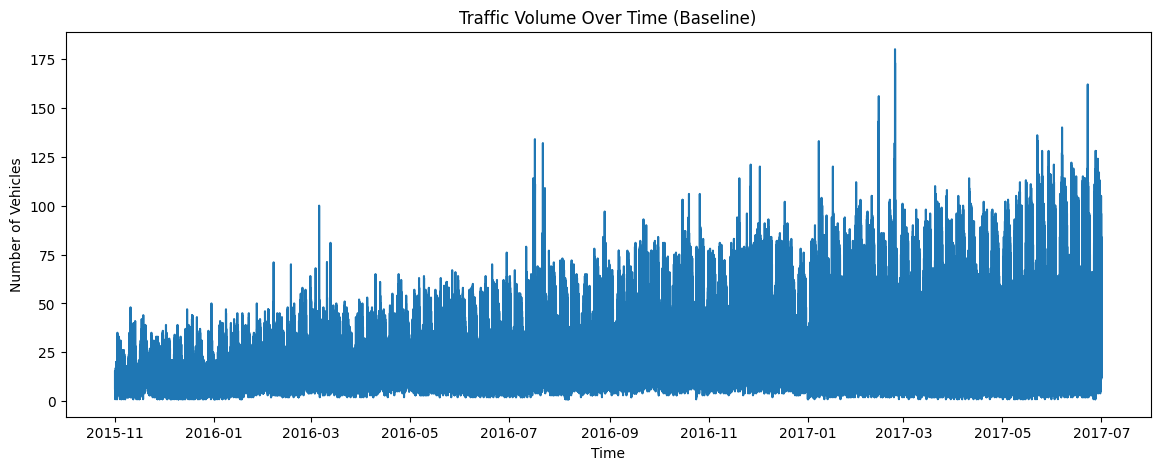

In [25]:
# =========================================
# BASELINE TRAFFIC VOLUME TREND
# =========================================

plt.figure(figsize=(14,5))
plt.plot(df['DateTime'], df['Vehicles'])
plt.title("Traffic Volume Over Time (Baseline)")
plt.xlabel("Time")
plt.ylabel("Number of Vehicles")
plt.show()


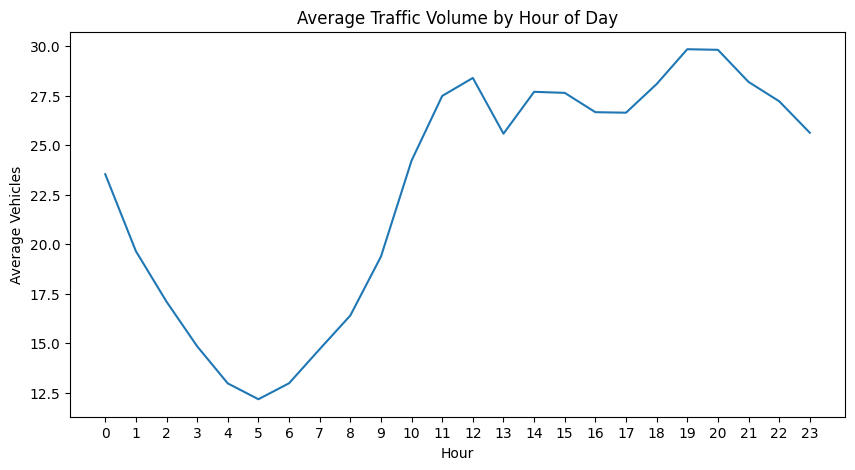

In [26]:
# =========================================
# HOURLY TRAFFIC PATTERN
# =========================================

hourly_avg = df.groupby('hour')['Vehicles'].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly_avg.index, hourly_avg.values)
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Vehicles")
plt.xticks(range(0,24))
plt.show()


## Phase 2A — Data Preparation for LSTM

In this phase, the cleaned dataset is transformed into a format suitable for LSTM modeling.

### Steps Performed
- Selected a single junction to reduce complexity.
- Isolated traffic volume as the prediction target.
- Normalized values using Min-Max scaling.
- Generated time-series sequences using a 24-hour sliding window.
- Split data into training and testing sets while preserving temporal order.

### Output
- `X_train`, `y_train` for model training
- `X_test`, `y_test` for evaluation

These sequences capture temporal dependencies required for LSTM learning.


In [27]:
# =========================================
# PHASE 2A: LSTM DATA PREPARATION
# =========================================

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1) Select ONE junction (recommended for first model)
junction_id = 1
df_junction = df[df['Junction'] == junction_id].copy()

print("Selected Junction:", junction_id)
print("Shape:", df_junction.shape)

# 2) Keep only DateTime and target variable
data = df_junction[['DateTime', 'Vehicles']].set_index('DateTime')

# 3) Normalize traffic volume (LSTM requirement)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(data[['Vehicles']])

# 4) Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # 24 hours window

X, y = create_sequences(scaled_values, SEQ_LENGTH)

print("X shape:", X.shape)
print("y shape:", y.shape)

# 5) Train-test split (time-aware, no shuffling)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Selected Junction: 1
Shape: (14592, 8)
X shape: (14568, 24, 1)
y shape: (14568, 1)
Training samples: 11654
Testing samples: 2914


## Phase 2B — LSTM Model Development and Training

In this phase, an LSTM neural network was designed and trained to predict hourly traffic volume.

### Model Architecture
- Two stacked LSTM layers with 50 units each
- Fully connected output layer
- Adam optimizer with Mean Squared Error loss

### Training Strategy
- 30 epochs with early stopping
- Learning monitored using validation loss
- Overfitting prevented through early stopping

### Output
- Trained LSTM model
- Training and validation loss history


In [28]:
# =========================================
# PHASE 2B: LSTM MODEL DEVELOPMENT
# =========================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1) Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

# 2) Compile model
model.compile(
    optimizer='adam',
    loss='mse'
)

# 3) Model summary (for documentation)
model.summary()

# 4) Train model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 2/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 3/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 4/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 5/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 6/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.4199e-04 - val_loss: 0.0021
Epoch 7/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.8803e-04 - val_loss: 0.0020
Epoch 8/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.2113e-04 - val_loss: 0.0019
Epoch 9/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8.6877e-04 - val_loss: 0.0022
Epoch 10/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.6934e-04 - val_loss: 0.0020
Epoch 11/30
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.5854e-04 - val_loss: 0.0023
Epoch 12/30
328/328 ━━━━━━

## Phase 2C — Model Evaluation (RMSE, MAE) and Prediction Visualization

In this phase, the trained LSTM model is evaluated on unseen test data.

### Steps Performed
- Generated traffic volume predictions on the test set.
- Converted predictions back to the original scale using inverse Min-Max scaling.
- Evaluated the model using:
  - **RMSE (Root Mean Squared Error)**
  - **MAE (Mean Absolute Error)**
- Visualized model performance by plotting **Actual vs Predicted** traffic volume.

### Output
- RMSE and MAE values for model performance
- Prediction plot showing how closely the model follows real traffic trends


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 6.0897
MAE:  4.5275


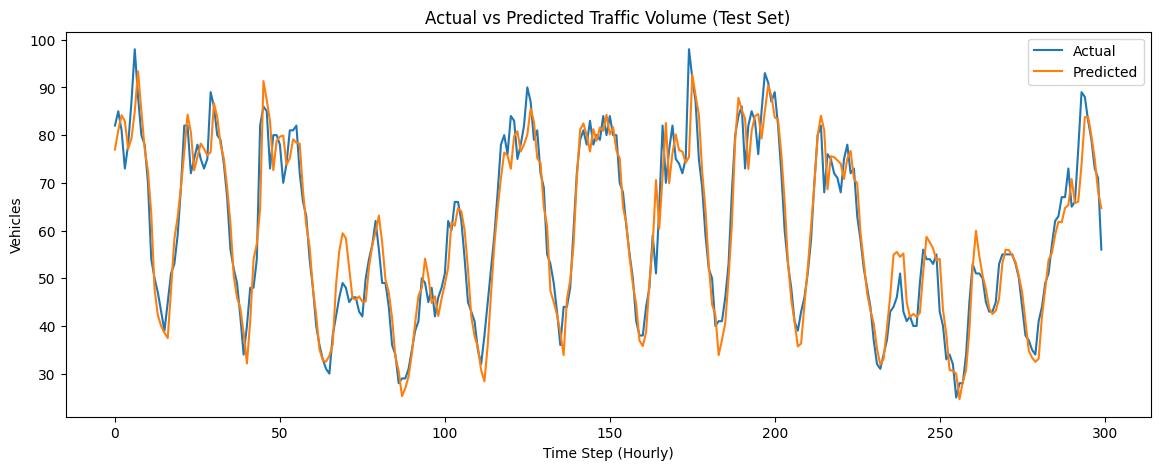

In [29]:
# =========================================
# PHASE 2C: EVALUATION (RMSE, MAE + PLOTS)
# =========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Predict on test set
y_pred_scaled = model.predict(X_test)

# 2) Inverse transform back to original "Vehicles" scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred_scaled)

# 3) Compute metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# 4) Plot Actual vs Predicted (first 300 points for readability)
N = 300

plt.figure(figsize=(14,5))
plt.plot(y_test_inv[:N], label="Actual")
plt.plot(y_pred_inv[:N], label="Predicted")
plt.title("Actual vs Predicted Traffic Volume (Test Set)")
plt.xlabel("Time Step (Hourly)")
plt.ylabel("Vehicles")
plt.legend()
plt.show()


## Saving The Model

In [30]:
# Save trained LSTM model
model.save("/content/lstm_traffic_model.keras")

print("Model saved successfully.")


Model saved successfully.


## Model Persistence

The trained LSTM model and data scaler were saved to Google Drive to ensure persistence and reproducibility. This allows the model to be reused for deployment without retraining and protects the project artifacts from runtime disconnections.


In [31]:
# =========================================
# SAVE PROJECT TO GOOGLE DRIVE
# =========================================

from google.colab import drive
import os

# 1) Mount Google Drive
drive.mount('/content/drive')

# 2) Create project directory (only once)
project_dir = "/content/drive/MyDrive/LSTM_Traffic_Prediction_Project"
os.makedirs(project_dir, exist_ok=True)

# 3) Save trained LSTM model
model_path = os.path.join(project_dir, "lstm_traffic_model.keras")
model.save(model_path)

print("Model saved at:", model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved at: /content/drive/MyDrive/LSTM_Traffic_Prediction_Project/lstm_traffic_model.keras


In [32]:
# =========================================
# SAVE SCALER
# =========================================

import joblib

scaler_path = os.path.join(project_dir, "minmax_scaler.save")
joblib.dump(scaler, scaler_path)

print("Scaler saved at:", scaler_path)


Scaler saved at: /content/drive/MyDrive/LSTM_Traffic_Prediction_Project/minmax_scaler.save


## Phase 3 — Step 1: Environment Reset and Artifact Verification

Before deployment, we reset any running processes from previous attempts and verify that the trained artifacts are safely stored in Google Drive.

### Actions
- Stopped any previously running Streamlit/tunneling processes.
- Mounted Google Drive.
- Verified presence of:
  - `lstm_traffic_model.keras` (trained LSTM model)
  - `minmax_scaler.save` (MinMaxScaler used during training)
- Listed project folder contents to confirm correct file paths.

### Output
Confirmed model and scaler files exist and are ready for deployment.


In [37]:
# =========================================
# PHASE 3 (STEP 1): CLEAN RESTART + VERIFY FILES
# =========================================

# 1) Stop anything left running (Streamlit/ngrok/etc.)
!pkill -f streamlit || true
!pkill -f ngrok || true
!pkill -f cloudflared || true

# 2) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3) Verify artifacts exist
import os

project_dir = "/content/drive/MyDrive/LSTM_Traffic_Prediction_Project"
model_path = os.path.join(project_dir, "lstm_traffic_model.keras")
scaler_path = os.path.join(project_dir, "minmax_scaler.save")

print("Project dir:", project_dir)
print("Model exists:", os.path.exists(model_path), "|", model_path)
print("Scaler exists:", os.path.exists(scaler_path), "|", scaler_path)

# 4) List folder contents
print("\nFolder contents:")
print(os.listdir(project_dir))


^C
^C
^C
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project dir: /content/drive/MyDrive/LSTM_Traffic_Prediction_Project
Model exists: True | /content/drive/MyDrive/LSTM_Traffic_Prediction_Project/lstm_traffic_model.keras
Scaler exists: True | /content/drive/MyDrive/LSTM_Traffic_Prediction_Project/minmax_scaler.save

Folder contents:
['lstm_traffic_model.keras', 'minmax_scaler.save']


## Phase 3 — Step 2: Web Application Development

A Streamlit-based web application was created to deploy the trained LSTM traffic prediction model.

### Features
- Loads the trained LSTM model and scaler from Google Drive
- Accepts traffic volume values for the previous 24 hours
- Predicts traffic volume for the next hour
- Displays results in a user-friendly interface

### Output
A complete `app.py` file ready for deployment.


In [38]:
# =========================================
# PHASE 3 (STEP 2): CREATE STREAMLIT APP
# =========================================

app_code = r'''
import numpy as np
import streamlit as st
import tensorflow as tf
import joblib
import os

# ------------------------------
# Page Configuration
# ------------------------------
st.set_page_config(
    page_title="Traffic Volume Prediction (LSTM)",
    page_icon="🚦",
    layout="centered"
)

st.title("🚦 Traffic Volume Prediction System")
st.write(
    "This system predicts **next-hour traffic volume** using a trained "
    "**LSTM model** based on the I-94 Traffic Dataset."
)

# ------------------------------
# Load Model & Scaler
# ------------------------------
PROJECT_DIR = "/content/drive/MyDrive/LSTM_Traffic_Prediction_Project"
MODEL_PATH = os.path.join(PROJECT_DIR, "lstm_traffic_model.keras")
SCALER_PATH = os.path.join(PROJECT_DIR, "minmax_scaler.save")

@st.cache_resource
def load_artifacts():
    model = tf.keras.models.load_model(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    return model, scaler

model, scaler = load_artifacts()

# ------------------------------
# Input Section
# ------------------------------
st.subheader("Input: Last 24 Hourly Traffic Volumes")

st.info("Enter traffic volume values for the previous 24 hours.")

inputs = []
cols = st.columns(4)

for i in range(24):
    with cols[i % 4]:
        value = st.number_input(
            f"Hour {i+1}",
            min_value=0.0,
            value=50.0,
            step=1.0
        )
        inputs.append(value)

# ------------------------------
# Prediction
# ------------------------------
if st.button("Predict Next Hour Traffic"):
    data = np.array(inputs).reshape(-1, 1)

    data_scaled = scaler.transform(data)
    X_input = data_scaled.reshape(1, 24, 1)

    prediction_scaled = model.predict(X_input)
    prediction = scaler.inverse_transform(prediction_scaled)

    st.success(
        f"✅ **Predicted Traffic Volume (Next Hour): "
        f"{prediction[0][0]:.2f} vehicles**"
    )

# ------------------------------
# Footer
# ------------------------------
st.caption(
    "Model: LSTM | Window Size: 24 Hours | "
    "Dataset: I-94 Traffic Volume"
)
'''

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py created successfully.")


✅ app.py created successfully.


## Phase 3 — Step 3: Launch Streamlit Server

The Streamlit application was launched inside the Colab runtime on port 8501.

### Actions
- Installed deployment dependencies (Streamlit + joblib).
- Started the Streamlit server in the background.
- Verified successful startup by checking the server logs.

### Output
A running Streamlit server listening on port `8501`.


In [40]:
# =========================================
# PHASE 3 (STEP 3): RUN STREAMLIT LOCALLY
# =========================================

!pip -q install streamlit joblib

# Stop any previous Streamlit process (safe)
!pkill -f streamlit || true

# Run Streamlit in background and log output to a file
!streamlit run app.py --server.port 8501 --server.headless true > streamlit.log 2>&1 &

# Quick check: show last lines of log
!tail -n 20 streamlit.log


^C


## Phase 3 — Step 4A: Install Cloudflare Tunnel (cloudflared)

Cloudflare Tunnel was installed to expose the Streamlit app publicly from the Colab runtime.
All shell commands are executed using `!` in Colab.


In [47]:
# =========================================
# PHASE 3 (STEP 4A): INSTALL CLOUDFLARED (FIXED)
# =========================================

!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared
!mv cloudflared /usr/local/bin/cloudflared

!cloudflared --version


cloudflared version 2026.1.2 (built 2026-01-27-11:31 UTC)


In [48]:
!pkill -f streamlit || true
!pkill -f cloudflared || true
!lsof -i :8501 || true


^C
^C


In [49]:
# Start Streamlit in background and log output
!streamlit run app.py --server.port 8501 --server.headless true --server.address 0.0.0.0 > streamlit.log 2>&1 &

# Show logs (look for "Running on..." and no errors)
!tail -n 40 streamlit.log

# Confirm something is listening on port 8501
!lsof -i :8501 | head -n 5


## Phase 3 — Step 4B: Generate Public URL

A Cloudflare Tunnel is started to expose the Streamlit application running locally on port 8501.
The output provides a `trycloudflare.com` URL which can be used to access the system in a browser for live demo.


In [50]:
# =========================================
# PHASE 3 (STEP 4B): START PUBLIC TUNNEL
# =========================================

!cloudflared tunnel --url http://localhost:8501


2026-01-29T16:20:08Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-29T16:20:08Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-29T16:20:13Z INF +--------------------------------------------------------------------------------------------+
2026-01-29T16:20:13Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-29T16:20:13Z INF |  https://zero-highlight-bring-seriously.trycloudflare.